In [1]:
# Project 
# Sugandhi Akula
# Rushya Puttam

Installing **pySpark** 

In [2]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 73kB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=df81ea5b6c80411cc7886d4abf0ae41c21f9a5722ba1371826ff9252ce631a41
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


**Importing necessary libraries**

In [3]:
import sys
from pyspark import SparkContext, SparkConf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sc = SparkContext("local","PySpark k-means clustering")

**Reading the given input file and changing to the format (obsno, array(points of type float))**

In [6]:
# 4601 rows and 58 columns
file = '/content/drive/XXXXXXXXXXXXXX/data.txt'

In [7]:
fileRDD = sc.textFile(file,minPartitions=20)

In [8]:
fileRDD=fileRDD.zipWithIndex().map(lambda x:(x[1],np.array([float(y) for y in x[0].split()])))

**Getting the intial cluster centres. Randomly picked 10 points from the data**

In [9]:
initial_centroid=random.sample(range(4601),10)

In [10]:
#Obs numbers of the initia cluster centers
initial_centroid

[4490, 15, 1160, 413, 78, 1846, 1649, 3063, 1135, 292]

In [11]:
#Getting the corodinates of initial centres and broadcasting the centres with the format (obsno/clusterno,data point)
initi_centroid_centres=fileRDD.filter(lambda x:x[0] in initial_centroid)

**Assigning the cluster number,cost function for each obs in input file by doing 20 iterations with 10 cluster centres**

In [12]:
#Function to calculate the euclidean distance and assignment of datapoint to the cluster with least distance. 
# Function to calculate the euclidean distance and assignment of datapoint to the cluster with least distance. 
# Function parameters:
# 1. x: Each line of the RDD
# 2. n : Number of clusters
# Function returns : 
  #temp is clusterid-obs number
  #x[0] is obs number
  #x[1] is coordinates 
  #costf is cst function for the datapoint
def euc_distance_assign_cluster(x,n):
  temp=0
  dist=np.inf
  for i in range(n):
    d = np.sqrt(sum(np.square(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    if d < dist:
      dist = d
      temp=centroid_centres_bd.value[i][0]
      costf=dist**2
  return (temp,(x[0],x[1],costf))

In [13]:
# Function to calculate the manhattan distance and assignment of datapoint to the cluster with least distance. 
# Function parameters:
# 1. x: Each line of the RDD
# 2. n : Number of clusters
# Function returns : 
  #temp is clusterid-obs number
  #x[0] is obs number
  #x[1] is coordinates 
  #costf is cst function for the datapoint
def man_distance_assign_cluster(x,n):
  temp=0
  dist=np.inf
  for i in range(n):
    d = np.sqrt(sum(np.absolute(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    if d < dist:
      dist = d
      temp=centroid_centres_bd.value[i][0]
      cost=dist**2
  return (temp,(x[0],x[1],cost))

**kmeans Algorithm**

In [14]:
# 20 iterations with 10 cluster loop
# 20 iterations with 10 cluster loop
# Function to run Kmeans algorithm
# Function parameters: 
# 1. method = "e" for euclidean or "m" for  manhattan
# 2. n_clus = Number of cluster :10
# 3. n_iter = Number of iterations: 20
# Function returns: List of cost function values for each iteration
def kmeans(method, n_clus, n_iter):
  cf=[]
  method = method.lower()
  global centroid_centres_bd
  centroid_centres_bd=sc.broadcast(initi_centroid_centres.collect())
  for i in range(n_iter):
    if method == 'e':
      assign_cluster=fileRDD.map(lambda x: euc_distance_assign_cluster(x,n_clus))
    elif method == 'm':
      assign_cluster=fileRDD.map(lambda x: man_distance_assign_cluster(x,n_clus))
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    centroid_centres_bd.unpersist()
    centroid_centres_bd=sc.broadcast(new_clusters.collect())  
  #Now, assign_cluster has 4601 observations and its correspoding cluster number after 20 iterations
  return cf

In [23]:
costs_eu = kmeans('e', 10, 20)
km_centroids_eu=[x[1] for x in centroid_centres_bd.value]
costs_man = kmeans('m', 10, 20)
km_centroids_man=[x[1] for x in centroid_centres_bd.value]

**Plotting cost functions**

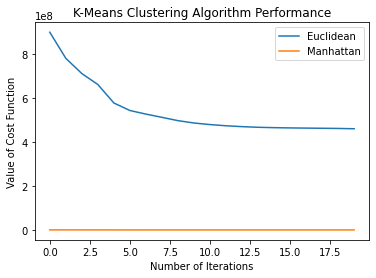

In [24]:
x = range(20)
y = costs_eu
z = costs_man

fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(x,z)
ax.set_title('K-Means Clustering Algorithm Performance')
ax.legend(['Euclidean','Manhattan'])
ax.xaxis.set_label_text('Number of Iterations')
ax.yaxis.set_label_text('Value of Cost Function')

plt.show()

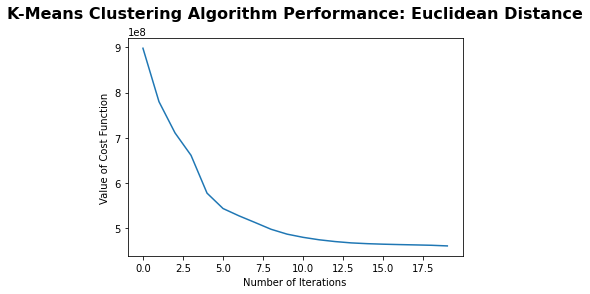

In [25]:
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
plt.title('K-Means Clustering Algorithm Performance: Euclidean Distance',pad=20,fontsize=16, fontweight='bold')
plt.plot(range(20),costs_eu)

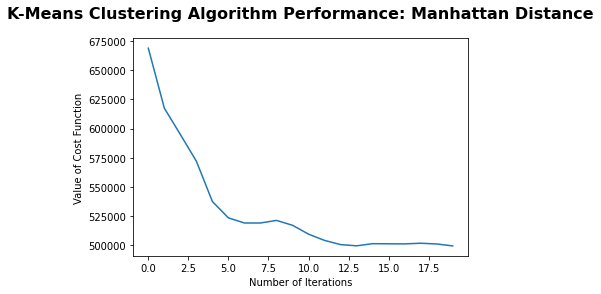

In [26]:
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
plt.title('K-Means Clustering Algorithm Performance: Manhattan Distance',pad=20,fontsize=16, fontweight='bold')
plt.plot(range(20),costs_man)

**Calculating % of change of cost fucntions after 10 iterations**

**#Reasoning**

As the number of iterations increase, the cost function value tends to fall. The same trend is observed for both euclidean and Manhattan distance cost functions. However, when the cost function is compared for euclidean and manhattan distances, manahattan has lower cost function values than euclidean. This is because while using the euclidean distance, we are able to achieve a greater decrease in the cost function over the first few iterations when compared to using the Manhattan distance.The value of the cost function first falls and then rises before plummeting again as evident frmo the above plot. That being said, at the end of 20 iterations, the value of cost function is lower when Manhattan distances are employed than when euclidean distances are employed

In [27]:
per_chan_e=round(((costs_eu[0]-costs_eu[9])/costs_eu[0])*100,2)
print("Percentage Change of Cost fucntion after 10 iterations for Euclidean Φ: " + str(per_chan_e))

Percentage Change of Cost fucntion after 10 iterations for Euclidean Φ: 45.89


In [28]:
per_chan_m=round(((costs_man[0]-costs_man[9])/costs_man[0])*100,2)
print("Percentage Change of Cost fucntion after 10 iterations for Manhattan Ψ: " + str(per_chan_m))

Percentage Change of Cost fucntion after 10 iterations for Manhattan Ψ: 22.73


**Saving the centroids into a text file**

In [29]:
with open('/content/driveXXXXXXXXXXXXXXXX/kmeans_centriods_eu.txt', "w") as output:
    output.write(str(km_centroids_eu))

In [30]:
with open('/content/drive/XXXXXXXXXXXXXXXXXXXXXX/kmeans_centriods_man.txt', "w") as output:
    output.write(str(km_centroids_man))